# Machine Learning with PySpark
It is important to note that this dataset is not specifically designed for regression models. However, for practice purpose, we will use it to build models that predict the total number of people affected by a natural disaster based on other features. We will train the following models:

1. Linear regression

2. Random forest regressor

4. GBT regressor

The results show that Random forest  and GBT regressors have the lowest MAE and RMSE, which suggests they are the best models 

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark import sql, SparkContext, SparkConf
from pyspark.sql.functions import *
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

plt.rcParams.update({'font.size': 15})

In [3]:
# Import custom class
%run -i '../src/4-pyspark-transfxn.py'

In [4]:
# Instantiate class
transfxn = TransformationPipeline(label_col = 'total_affected')

In [5]:
# Create spark session
spark = SparkSession.builder.appName("project").getOrCreate()

# Load data

In [5]:
 # load data
df_raw = spark.read.csv('../data/ml_data.csv', inferSchema = True, header = True) 
df_raw.createOrReplaceTempView("raw_table") # create table for sql query

# print data size and display sample
print("Data size:", (df_raw.count(), len(df_raw.columns))) 

cols = ['year', 'continent', 'disaster_type',  'no_occurrence', 'total_deaths', 'no_injured',
         'no_affected', 'total_damages_(us$)'
         ]
df_raw.select(cols).show()

Data size: (15901, 24)
+----+---------+-------------+-------------+------------+----------+-----------+-------------------+
|year|continent|disaster_type|no_occurrence|total_deaths|no_injured|no_affected|total_damages_(us$)|
+----+---------+-------------+-------------+------------+----------+-----------+-------------------+
|1900|   Africa|      Drought|          7.0|     11000.0|       0.0|        0.0|                0.0|
|1900|     Asia|      Drought|          7.0|   1250000.0|       0.0|        0.0|                0.0|
|1902| Americas|   Earthquake|         10.0|      2000.0|       0.0|        0.0|            25000.0|
|1902| Americas|        Other|         10.0|      1000.0|       0.0|        0.0|                0.0|
|1902| Americas|        Other|         10.0|      6000.0|       0.0|        0.0|                0.0|
|1903| Americas|        Other|         12.0|        76.0|      23.0|        0.0|                0.0|
|1903|   Africa|        Other|         12.0|        17.0|       0.0|

In [6]:
df_raw.printSchema()

root
 |-- iso: string (nullable = true)
 |-- country: string (nullable = true)
 |-- region: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- disaster_type: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- local_time: string (nullable = true)
 |-- start_month: double (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- no_injured: double (nullable = true)
 |-- no_affected: double (nullable = true)
 |-- no_homeless: double (nullable = true)
 |-- total_affected: double (nullable = true)
 |-- total_damages_(us$): double (nullable = true)
 |-- cpi: double (nullable = true)
 |-- local_hour: double (nullable = true)
 |-- year_in_decade: integer (nullable = true)
 |-- no_occurrence: double (nullable = true)
 |-- occur_per_contnt: integer (nullable = true)
 |-- total_affected_per_occur: double (nullable = true)
 |-- total_affected_per_contnt: double (nullable = 

# Select features for modeling

In [7]:
cols = ['continent', 'disaster_type','start_month','total_deaths',
        'no_injured','no_affected', 'no_homeless','total_affected',
        'total_damages_(us$)', 'year', 'cpi', 'local_hour', 'no_occurrence',
        'total_affected_per_occur', 'total_affected_per_contnt','total_affected_per_year',
        'occur_per_contnt'
        ]

df = df_raw.select(cols)

# Data types and missing values
As indicated in the [data source](https://www.emdat.be), the missing values in some numerical columns should be set to zero. However, missing values in other columns such as local_hour, start_month will be imputed in data pre-processing 

In [8]:
df_missing = df.agg(*[count(c).alias(c) for c in df.columns])

cols = ['year', 'total_deaths','disaster_type', 'no_injured','no_affected', 'no_homeless', 
        'total_affected'
        ]
df_missing.select(cols).show()

+-----+------------+-------------+----------+-----------+-----------+--------------+
| year|total_deaths|disaster_type|no_injured|no_affected|no_homeless|total_affected|
+-----+------------+-------------+----------+-----------+-----------+--------------+
|15901|       15901|        15901|     15901|      15901|      15901|         15901|
+-----+------------+-------------+----------+-----------+-----------+--------------+



In [9]:
# # Fill missing values in those columns with 0
# num_cols = ['total_deaths', 'no_injured', 'total_damages_(us$)', 
#             'no_affected', 'no_homeless', 'total_affected'
#             ]
# df = transfxn.one_val_imputer(df, num_cols, impute_with = 0)

# # Cross-check
# df.agg(*[count(c).alias(c) for c in num_cols]).show()

# Encode month categorical variable as string

In [10]:
@pandas_udf("string")

def replace_month(x: pd.Series) -> pd.Series:
    """ 
    pandas udf for replacing values with other values
    """
    param_dict = {'1':'Jan', '2':'Feb', '3':'Mar',
                    '4':'Apr', '5':'May', '6':'Jun', 
                    '7':'Jul', '8':'Aug', '9':'Sep',
                    '10':'Oct', '11':'Nov', '12':'Dec'
                    }
    return x.replace(param_dict)

In [11]:
# Convert month to string type
df = df.withColumn('start_month', df['start_month'].cast(StringType()))

# Replace integer coding with string coding
df = df.withColumn('start_month', replace_month(df['start_month']))


In [12]:
df.groupBy('start_month')\
    .count()\
    .sort(desc("count"))\
    .show()

+-----------+-----+
|start_month|count|
+-----------+-----+
|        1.0| 1759|
|        8.0| 1630|
|        7.0| 1599|
|        9.0| 1441|
|       10.0| 1283|
|        6.0| 1279|
|        5.0| 1200|
|       12.0| 1123|
|        4.0| 1098|
|       11.0| 1052|
|        2.0| 1029|
|        3.0| 1023|
|       null|  385|
+-----------+-----+



In [13]:
# Fill null with the mode
df = transfxn.one_val_imputer(df, ['start_month'], impute_with = 'Jan')

# Correlation matrix

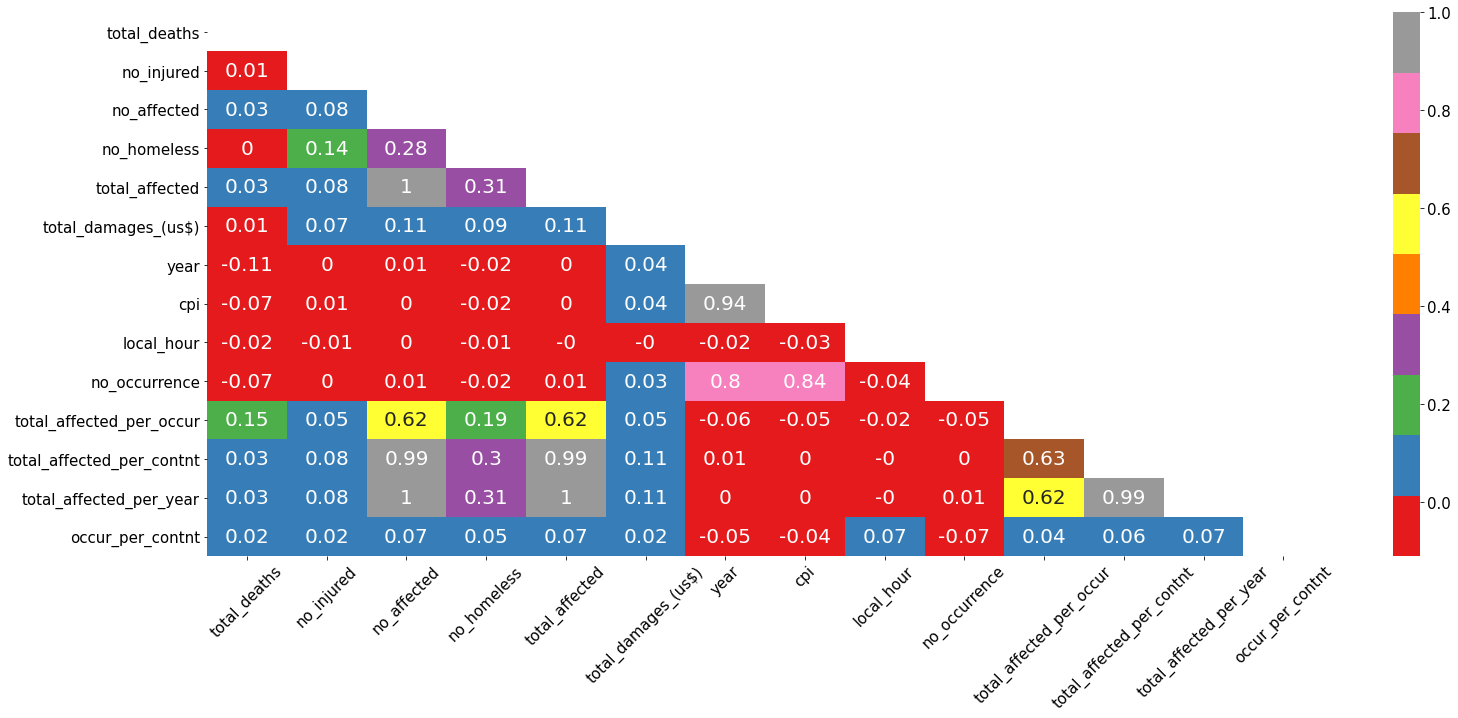

In [14]:
fig, ax = plt.subplots(figsize=(25,10))

# Correlation matrix
corr_matrix = df.toPandas().corr()

# Plot chart
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(np.round(corr_matrix, 2), annot=True, annot_kws={"size": 20},
            mask = mask, cmap = plt.get_cmap("Set1"),ax = ax)
plt.xticks(rotation = 45)
plt.show()

# Log transformation 
Logarithm transformation of  all the numerical variables is perfomed

In [15]:
@pandas_udf("double")

def log_udf(x: pd.Series) -> pd.Series:
    """ 
    UDF of log(1+x) transformation 
    """
    return np.log1p(x)

def log_transfxn(df, cat_cols):
    """
    Log(1+x) transformation  of numerical variables
    """
    cols = [x for x in df.columns if x not in cat_cols]
    for col in cols:
        df = df.withColumn(col, log_udf(df[col]))
    return df

In [16]:
# Log(1+x) transformation   
dont_cols = ['continent','disaster_type', 'start_month']
df = log_transfxn(df, dont_cols)

# Plot distribution of target variable

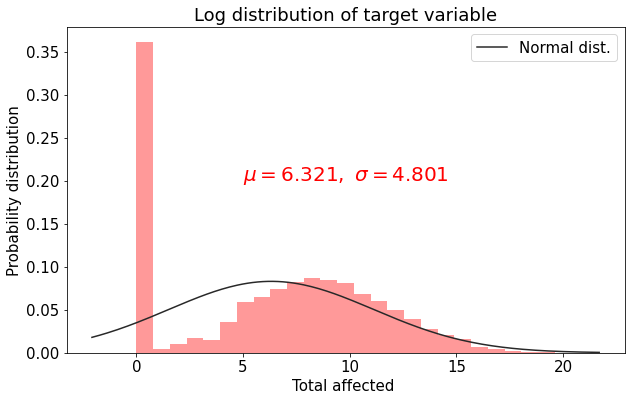

In [17]:
# Set figure size
fig = plt.figure(figsize = (10,6))

# Convert to pandas for plotting
pdf = df.toPandas()

# Mean and std of the target variable
mu = np.round(pdf['total_affected'].mean(),3)
sigma = np.round(pdf['total_affected'].std(),3)

# Plot distribution
sns.distplot(pdf['total_affected'], kde=False, fit = norm, color = 'r')
plt.legend(['Normal dist.'],loc='best')
plt.text(5, 0.2, r'$\mu = {},~ \sigma = {}$'.\
         format(str(mu), str(sigma)),
         color = 'r',  fontsize=20)
plt.xlabel('Total affected ')
plt.ylabel('Probability distribution')
plt.title("Log distribution of target variable")
plt.show()

# Create a Test Set
We split the data into 50 $\%$ training set, 30 $\%$ validation set,  and 20 $\%$ test set


In [18]:
trainDF, validDF, testDF = df.randomSplit([.5, 0.3, .2], seed=42)

In [19]:
print('Training set size:', (trainDF.count(), len(trainDF.columns)))
print('Validation set size:', (validDF.count(), len(validDF.columns)))
print('Test set size:', (testDF.count(), len(testDF.columns)))

Training set size: (8062, 17)
Validation set size: (4719, 17)
Test set size: (3120, 17)


# Transformation Pipelines

In [23]:
# Transform and scale data
assembler, trainDF_scaled, validDF_scaled, testDF_scaled = transfxn.preprocessing(trainDF, validDF, testDF)

In [24]:
cols = ['features', 'total_affected','start_month', 'continent']
trainDF_scaled.select(cols).show(5)

+--------------------+------------------+-----------+---------+
|            features|    total_affected|start_month|continent|
+--------------------+------------------+-----------+---------+
|(36,[2,9,11,28,29...|               0.0|        1.0|   Africa|
|(36,[2,9,11,28,29...|               0.0|        1.0|   Africa|
|(36,[2,9,11,25,27...| 9.392745258631441|        1.0|   Africa|
|(36,[2,9,11,25,28...|10.663147865904188|        1.0|   Africa|
|(36,[2,9,11,25,28...| 11.51293546492023|        1.0|   Africa|
+--------------------+------------------+-----------+---------+
only showing top 5 rows



# A. Linear Regression

In [25]:
# Train a linear regression model.
lr = LinearRegression(labelCol = "total_affected", featuresCol = "features")

# Fit the training set 
lr_model = lr.fit(trainDF_scaled)

# Make predictions on the validation set
lr_val_pred = lr_model.transform(validDF_scaled)

# Select example rows to display
cols = ["features", "total_affected", "prediction"]
lr_val_pred.select(cols).show(5)

+--------------------+--------------+------------------+
|            features|total_affected|        prediction|
+--------------------+--------------+------------------+
|(36,[2,9,11,28,29...|           0.0|0.1572637967863102|
|(36,[2,9,11,28,29...|           0.0|0.1572637967863102|
|(36,[2,9,11,28,29...|           0.0|  0.91321354851857|
|(36,[2,9,11,28,29...|           0.0|1.1390974517250925|
|(36,[2,9,11,27,28...|           0.0| 1.487008820490928|
+--------------------+--------------+------------------+
only showing top 5 rows



In [26]:
# lr_model.summary

## A-1: Performance metrics on the validation set

In [33]:
transfxn.eval_metrics(lr_val_pred, model_nm = 'Linear Regression')

Performance metrics for Linear Regression
----------------------------------------
{'MSE = 1.432', 'R^2 = 0.938', 'RMSE = 1.197', 'MAE = 0.972'}


## A-2: Performance metrics on the test set

In [34]:
# Make predictions on the test set
lr_test_pred = lr_model.transform(testDF_scaled)

transfxn.eval_metrics(lr_test_pred, model_nm = 'Linear Regression')

Performance metrics for Linear Regression
----------------------------------------
{'MAE = 0.963', 'R^2 = 0.94', 'RMSE = 1.181', 'MSE = 1.396'}


# B. Random Forest Regressor

In [35]:
# Train a random forest regression model.
rf = RandomForestRegressor(labelCol = "total_affected", featuresCol = "features", 
                          numTrees = 100,  maxDepth = 5
                          )

# Fit the training set 
rf_model = rf.fit(trainDF_scaled)

# Make predictions on the validation set
rf_val_pred = rf_model.transform(validDF_scaled)

# Select example rows to display
cols = ["features", "total_affected", "prediction"]
rf_val_pred.select(cols).show(5)

+--------------------+--------------+--------------------+
|            features|total_affected|          prediction|
+--------------------+--------------+--------------------+
|(36,[2,9,11,28,29...|           0.0|0.006402831939865559|
|(36,[2,9,11,28,29...|           0.0|0.006402831939865559|
|(36,[2,9,11,28,29...|           0.0|0.006402831939865559|
|(36,[2,9,11,28,29...|           0.0|0.006402831939865559|
|(36,[2,9,11,27,28...|           0.0| 0.00712821765254943|
+--------------------+--------------+--------------------+
only showing top 5 rows



## B-1: Performance metrics on the validation set

In [36]:
transfxn.eval_metrics(rf_val_pred, model_nm = 'Random Forest Regressor')

Performance metrics for Random Forest Regressor
----------------------------------------
{'MSE = 0.073', 'MAE = 0.138', 'R^2 = 0.997', 'RMSE = 0.27'}


## B-2. Feature importances

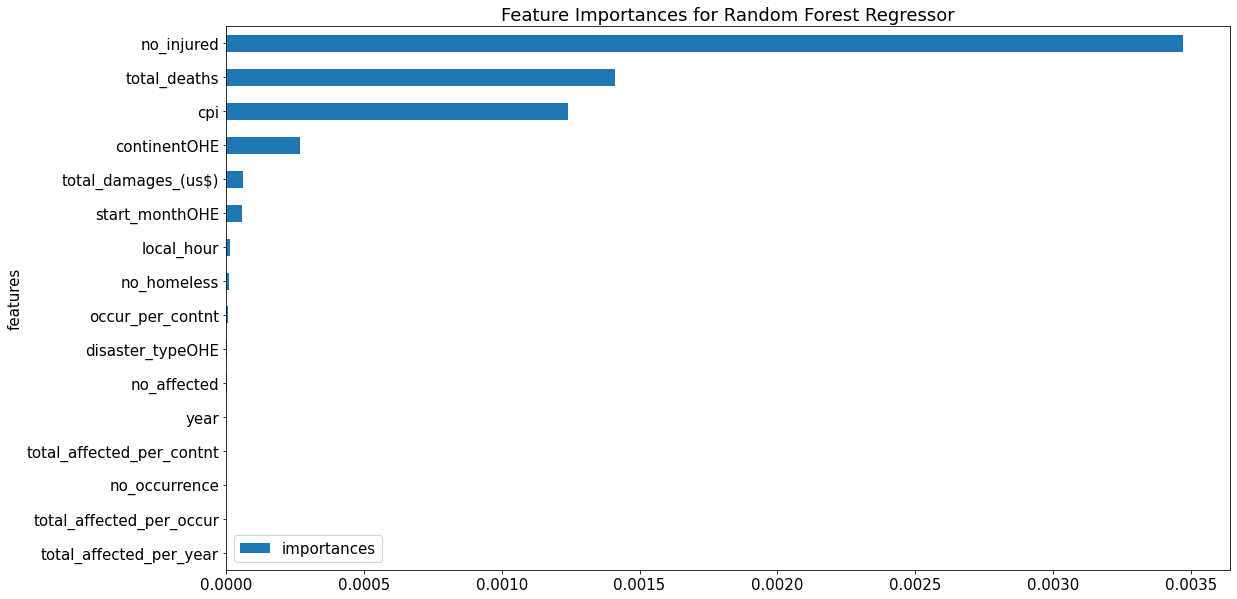

In [37]:
# Feature importances
feature_imp = pd.DataFrame(
      list(zip(assembler.getInputCols(), rf_model.featureImportances)), 
      columns=["features", "importances"]
      )

# Plot bar chart
feature_imp.sort_values('importances', ascending = True, inplace = True)
feature_imp.set_index('features', inplace = True)
feature_imp.plot(kind='barh', figsize = (18,10))
plt.title('Feature Importances for Random Forest Regressor')
plt.show()

## B-3. Hyperparameter tuning
We now optimize the MAE of Random forest regressor using grid search and 5-fold cross-validation

In [43]:
paramGrid = ParamGridBuilder()\
            .addGrid(rf.maxDepth, [4,6,10])\
            .addGrid(rf.maxBins, [20,60])\
            .build()

evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol = "total_affected",
                                metricName = "mae")
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, 
numFolds=5, seed=42)

In [44]:
# Fit the training set
cv_model = cv.fit(trainDF_scaled)

# Make predictions on the validation set
rf_cv_pred = cv_model.transform(validDF_scaled)

In [45]:
list(zip(cv_model.getEstimatorParamMaps(), cv_model.avgMetrics))

[({Param(parent='RandomForestRegressor_4a81b04573e9', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4,
   Param(parent='RandomForestRegressor_4a81b04573e9', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20},
  0.24127755701653517),
 ({Param(parent='RandomForestRegressor_4a81b04573e9', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4,
   Param(parent='RandomForestRegressor_4a81b04573e9', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 60},
  0.22380573246162325),
 ({Param(parent='RandomForestRegressor_4a81b04573e9', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node;

In [46]:
transfxn.eval_metrics(rf_cv_pred, model_nm = 'Random Forest Regressor')

Performance metrics for Random Forest Regressor
----------------------------------------
{'R^2 = 0.999', 'RMSE = 0.112', 'MAE = 0.046', 'MSE = 0.013'}


## B-4. Performance metrics on the test set

In [47]:
rf_test_pred = cv_model.transform(testDF_scaled)
transfxn.eval_metrics(rf_test_pred, model_nm = 'Random Forest Regressor')

Performance metrics for Random Forest Regressor
----------------------------------------
{'MSE = 0.015', 'R^2 = 0.999', 'RMSE = 0.121', 'MAE = 0.045'}


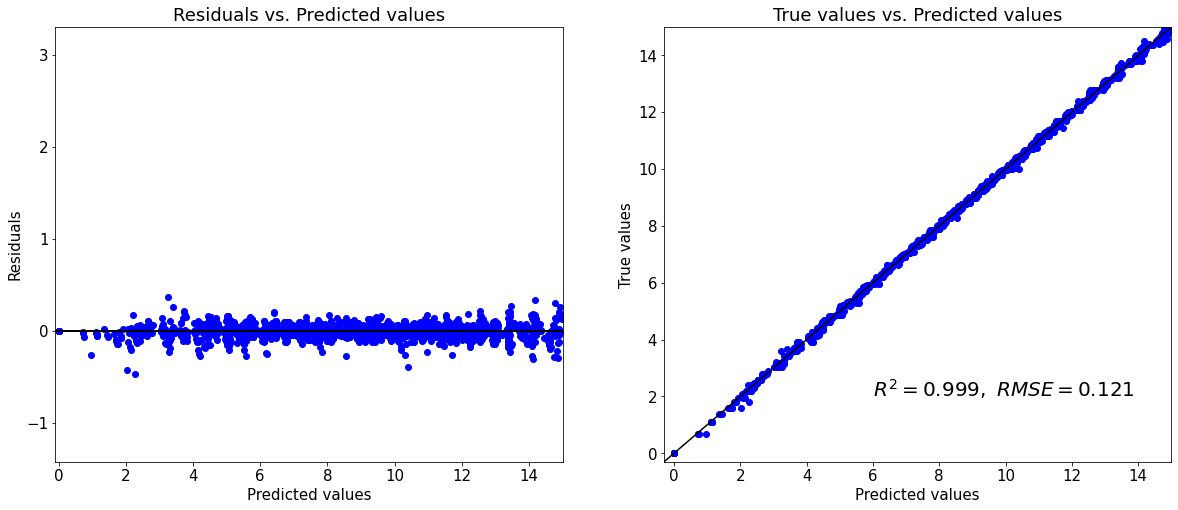

In [48]:
pdf_rf = rf_test_pred.select(['total_affected', 'prediction']).toPandas()
transfxn.diagnostic_plot(np.array(pdf_rf.total_affected), np.array(pdf_rf.prediction))

# C. GBT Regressor

In [40]:
# Train a random forest regression model.
gbt = GBTRegressor(labelCol = "total_affected", featuresCol = "features")

# Fit the training set 
gbt_model = gbt.fit(trainDF_scaled)

# Make predictions on the validation set
gbt_val_pred = gbt_model.transform(validDF_scaled)

# Select example rows to display
cols = ["features", "total_affected", "prediction"]
gbt_val_pred.select(cols).show(5)

+--------------------+--------------+--------------------+
|            features|total_affected|          prediction|
+--------------------+--------------+--------------------+
|(36,[2,9,11,28,29...|           0.0|-0.00385843550243...|
|(36,[2,9,11,28,29...|           0.0|-0.00385843550243...|
|(36,[2,9,11,28,29...|           0.0|-0.00385843550243...|
|(36,[2,9,11,28,29...|           0.0|-0.00385843550243...|
|(36,[2,9,11,27,28...|           0.0|0.001803188886337...|
+--------------------+--------------+--------------------+
only showing top 5 rows



## C-1. Performance metrics on the validation set

In [41]:
transfxn.eval_metrics(gbt_val_pred, model_nm = 'GBT Regressor')

Performance metrics for GBT Regressor
----------------------------------------
{'R^2 = 0.998', 'MSE = 0.036', 'MAE = 0.103', 'RMSE = 0.19'}


## C-2. Feature Importances

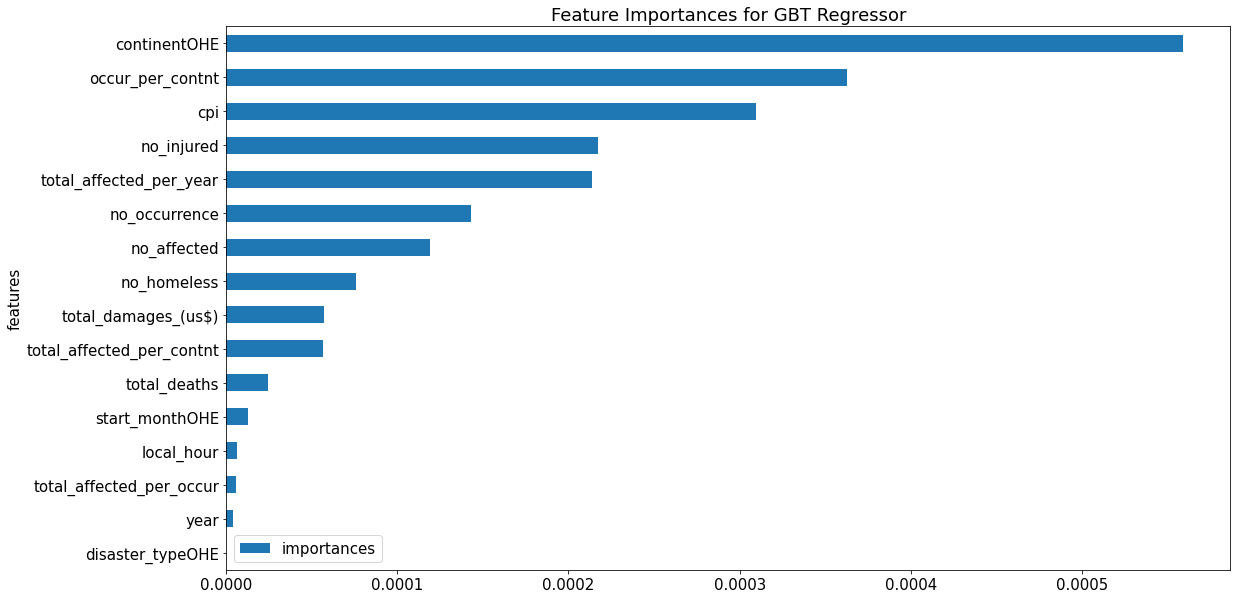

In [42]:
# Feature importances
feature_imp = pd.DataFrame(
      list(zip(assembler.getInputCols(), gbt_model.featureImportances)), 
      columns=["features", "importances"]
      )

# Plot bar chart
feature_imp.sort_values('importances', ascending = True, inplace = True)
feature_imp.set_index('features', inplace = True)
feature_imp.plot(kind='barh', figsize = (18,10))
plt.title('Feature Importances for GBT Regressor')
plt.show()

In [49]:
gbt_test_pred = gbt_model.transform(testDF_scaled)

transfxn.eval_metrics(gbt_test_pred, model_nm = 'GBT Regressor')

Performance metrics for GBT Regressor
----------------------------------------
{'R^2 = 0.998', 'MSE = 0.046', 'MAE = 0.107', 'RMSE = 0.214'}
